# 导入相关模组

In [1]:
import yaml
import pcse
#  import sys
import os
import pickle
import copy
import numpy as np
import pandas as pd

from Wofost_opt_NWLP import my_crop_dict, my_agro, ModelRerunner
from pcse.fileinput import YAMLCropDataProvider, CABOFileReader, YAMLAgroManagementReader
from pcse.exceptions import PCSEError, PartitioningError
from pcse.util import WOFOST80SiteDataProvider, WOFOST71SiteDataProvider
from pcse.base import ParameterProvider
from pcse.fileinput import YAMLAgroManagementReader
from pcse.fileinput import ExcelWeatherDataProvider
from pcse.models import Wofost80_NWLP_FD_beta as Wofost80_NWLP_FD
from pcse.models import Wofost72_WLP_FD
from tqdm import tqdm

In [2]:
data_dir = os.path.join(os.getcwd(), "data")

## 2.1 读取作物参数

In [3]:
cropfile = os.path.join(data_dir, 'npkfile', 'wofost_npk.crop')
cropd = CABOFileReader(cropfile)


## 2.2 土壤参数

In [4]:
soilfile = os.path.join(data_dir, 'soil', 'ec3_copy1.soil')
soild = CABOFileReader(soilfile)

## 2.3 站点数据

In [5]:
# NAVAILI       Amount of N available in the pool at initialization of the system [kg/ha] 0-32
# sited = WOFOST71SiteDataProvider(WAV=18)
sited = WOFOST80SiteDataProvider(WAV=18, NAVAILI=20.5, PAVAILI=50.0, KAVAILI=250.0)

## 2.4 合并数据

In [6]:
parameters = ParameterProvider(cropdata=cropd, soildata=soild, sitedata=sited)

## 2.5 读取管理文件

In [7]:
with open("./data/npkfile/wofost_npk2022.agro", 'r') as f:
    yaml_agro_2022 = f.read()
with open("./data/npkfile/wofost_npk2021.agro", 'r') as f:
    yaml_agro_2021 = f.read()

## 2.6 气象数据

In [8]:
weatherfile = os.path.join(data_dir, 'meteo', 'WOFOSTYL.xlsx')
wdp = ExcelWeatherDataProvider(weatherfile)

# 3 模型运行

In [9]:
def overwrite_para(params, param_dict):
    params.clear_override()
    params.set_override("TSUMEM", 125.0)
    params.set_override("TSUM1", 1300)
    params.set_override("TSUM2", 720)
    crop_dict = my_crop_dict()

    for parname, value in param_dict.items():

        tmp_name = parname.split("00")
        if len(tmp_name) == 2:
            var_name, idx1 = tmp_name[0], int(tmp_name[1])
            if var_name == "FLTB" or var_name == "FOTB":
                crop_dict[var_name][idx1] = value
                crop_dict['FSTB'][idx1] = 1 - crop_dict['FLTB'][idx1] - crop_dict['FOTB'][idx1]
                params.set_override(var_name, crop_dict[var_name])
                params.set_override("FSTB", crop_dict["FSTB"])
                # print("%s: %s" % (var_name, parameters[var_name]))
            else:
                crop_dict[var_name][idx1] = value
                params.set_override(var_name, crop_dict[var_name])

        else:
            var_name = parname
            params.set_override(var_name, value)
    return params

In [10]:
# 管理文件数据
agro = my_agro(yaml_agro_2022, 180)

In [11]:
param_dict = {'AMAXTB001': 81.7121888514895, 'CVS': 0.329121467457929, 'CVO': 0.9058005069724505, 'EFFTB001': 0.48336079258353787, 'EFFTB003': 0.6455378025518874, 'FLTB001': 0.6238628980908938, 'KDIFTB003': 0.7234994333878939, 'NCRIT_FR': 0.9110596892310302, 'NMAXSO': 0.015122114006625076, 'SLATB001': 0.0013528940745241608, 'SLATB003': 0.00140832568159012, 'SPAN': 49.30346137485921, 'TDWI': 30.99146290837611, 'TMNFTB003': 1.1870409185448094}

In [12]:
parameters = overwrite_para(params=parameters, param_dict=param_dict)

In [13]:
parameters['NAVAILI']

20.5

In [14]:
Wofost1 = Wofost80_NWLP_FD(parameters, wdp, agro)
Wofost1.run_till_terminate()
print(Wofost1.get_summary_output())

[{'DVS': 2.0, 'LAIMAX': 2.0951239693316706, 'TAGP': 13161.627935260181, 'TWSO': 7866.944539901459, 'TWLV': 1511.3984390856856, 'TWST': 3783.2849562730357, 'TWRT': 797.0755246178718, 'CTRAT': 15.237545983698826, 'RD': 100.0, 'DOS': datetime.date(2022, 6, 11), 'DOE': datetime.date(2022, 6, 19), 'DOA': datetime.date(2022, 8, 18), 'DOM': datetime.date(2022, 9, 27), 'DOH': None, 'DOV': None, 'CEVST': 11.293817742684688, 'NuptakeTotal': 131.96252748587682, 'PuptakeTotal': 34.37809293063995, 'KuptakeTotal': 179.84402903610612, 'NamountSO': 92.55112578192865, 'PamountSO': 29.954584508891372, 'KamountSO': 38.537656324994224}]


In [15]:
modelrerunner = ModelRerunner(parameters, wdp, agro)
result = modelrerunner(param_dict, flag=True)
print(result[1])

[{'DVS': 2.0, 'LAIMAX': 2.0951239693316706, 'TAGP': 13161.627935260181, 'TWSO': 7866.944539901459, 'TWLV': 1511.3984390856856, 'TWST': 3783.2849562730357, 'TWRT': 797.0755246178718, 'CTRAT': 15.237545983698826, 'RD': 100.0, 'DOS': datetime.date(2022, 6, 11), 'DOE': datetime.date(2022, 6, 19), 'DOA': datetime.date(2022, 8, 18), 'DOM': datetime.date(2022, 9, 27), 'DOH': None, 'DOV': None, 'CEVST': 11.293817742684688, 'NuptakeTotal': 131.96252748587682, 'PuptakeTotal': 34.37809293063995, 'KuptakeTotal': 179.84402903610612, 'NamountSO': 92.55112578192865, 'PamountSO': 29.954584508891372, 'KamountSO': 38.537656324994224}]


<AxesSubplot:xlabel='day'>

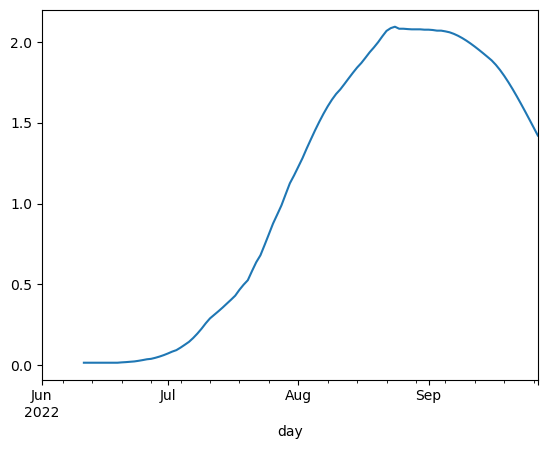

In [16]:
result[0].LAI.plot()

In [17]:

modelrerunner = Wofost80_NWLP_FD(parameters, wdp, agro)
modelrerunner.run_till_terminate()
print(modelrerunner.get_summary_output())

[{'DVS': 2.0, 'LAIMAX': 1.4624725006094215, 'TAGP': 7299.617521827588, 'TWSO': 4298.386018736899, 'TWLV': 919.5722932182789, 'TWST': 2081.6592098724095, 'TWRT': 479.42699833812105, 'CTRAT': 11.800432701791296, 'RD': 80.40000000000005, 'DOS': datetime.date(2022, 6, 11), 'DOE': datetime.date(2022, 6, 18), 'DOA': datetime.date(2022, 7, 20), 'DOM': datetime.date(2022, 8, 26), 'DOH': None, 'DOV': None, 'CEVST': 8.793022820326575, 'NuptakeTotal': 82.91717558045465, 'PuptakeTotal': 26.003547294326385, 'KuptakeTotal': 105.6450312103625, 'NamountSO': 61.61894974598381, 'PamountSO': 20.69443416078578, 'KamountSO': 20.49535040556597}]


In [18]:
agro

[{datetime.date(2022, 6, 1): {'CropCalendar': {'crop_name': 'maize',
    'variety_name': 'Grain_maize_201',
    'crop_start_date': datetime.date(2022, 6, 11),
    'crop_start_type': 'sowing',
    'crop_end_date': None,
    'crop_end_type': 'maturity',
    'max_duration': 140},
   'TimedEvents': [{'event_signal': 'irrigate',
     'name': 'Timed irrigation events',
     'comment': 'All irrigation amounts in cm',
     'events_table': [{datetime.date(2022, 6, 28): {'amount': 7.5,
        'efficiency': 0.9}},
      {datetime.date(2022, 7, 7): {'amount': 7.5, 'efficiency': 0.9}},
      {datetime.date(2022, 8, 8): {'amount': 7.5, 'efficiency': 0.9}}]},
    {'event_signal': 'apply_npk',
     'name': 'Timed N/P/K application table',
     'comment': 'All fertilizer amounts in kg/ha',
     'events_table': [{datetime.date(2022, 6, 11): {'N_amount': 108.0,
        'P_amount': 90.0,
        'K_amount': 60.0,
        'N_recovery': 0.7,
        'P_recovery': 0.7,
        'K_recovery': 0.7}},
      {da

In [19]:
# 参数顺序
parameters_name = ["SLATB001", "SLATB003", "SPAN", "EFFTB003", "TMNFTB003", "CVO", "FLTB003", "TDWI", "CVS",
                       "NCRIT_FR", "EFFTB001", "KDIFTB003", "AMAXTB001"]

In [22]:
param_df = pd.read_csv(os.path.join(data_dir, "opt", "opt1", "opt_ZDN180_NWLP_result.csv"), index_col=0)
param_df.sort_values(by=['rmse'], ascending=True, inplace=True)
# param_df = param_df[param_df['rmse'] < 0.31]

In [23]:
parameters_name = param_df.columns.to_list()
parameters_name = parameters_name[1: ]

In [24]:
sited = WOFOST80SiteDataProvider(WAV=18, NAVAILI=20.5, PAVAILI=50.0, KAVAILI=250.0)
parameters = ParameterProvider(cropdata=cropd, soildata=soild, sitedata=sited)

In [29]:
# 管理文件数据

rows, _ = param_df.shape
df_dict = dict()
for nn in [90, 180]:
    agro = my_agro(yaml_agro_2021, nn)
    modelrerunner = None
    modelrerunner = ModelRerunner(parameters, wdp, agro)
    twso_list = list()
    for i in tqdm([0]):
        p_value = dict()
        for each in parameters_name:
            p_value[each] = param_df.iloc[i][each]
        result = modelrerunner(p_value, flag=True)
        # if result[1][0]['TWSO'] > 8000:
        twso_list.append([i, result[1][0]['TWSO']])
    df1 = pd.DataFrame(twso_list, columns=["id", "TWSO"])
    df1.set_index("id", inplace=True)
    df_dict[str(nn)] = df1
    # print(result[0])
# print(modelrerunner.summary[0])

100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


In [32]:
df_dict["180"]

,TWSO
id,
0,9587.498924


In [33]:
result[1]

[{'DVS': 2.0,
  'LAIMAX': 5.017079467720782,
  'TAGP': 19722.6808300284,
  'TWSO': 9587.498924368643,
  'TWLV': 3466.2781173403,
  'TWST': 6668.903788319456,
  'TWRT': 2148.002154500457,
  'CTRAT': 25.55544413685283,
  'RD': 100.0,
  'DOS': datetime.date(2021, 6, 12),
  'DOE': datetime.date(2021, 6, 21),
  'DOA': datetime.date(2021, 8, 22),
  'DOM': datetime.date(2021, 10, 1),
  'DOH': None,
  'DOV': None,
  'CEVST': 3.8382230225246365,
  'NuptakeTotal': 146.50000000000003,
  'PuptakeTotal': 48.41766652062588,
  'KuptakeTotal': 388.9542127743453,
  'NamountSO': 94.91066201274948,
  'PamountSO': 41.82910220037272,
  'KamountSO': 49.42681150370075}]

3.0

In [31]:
res_2021 = result[0]

<AxesSubplot:xlabel='day'>

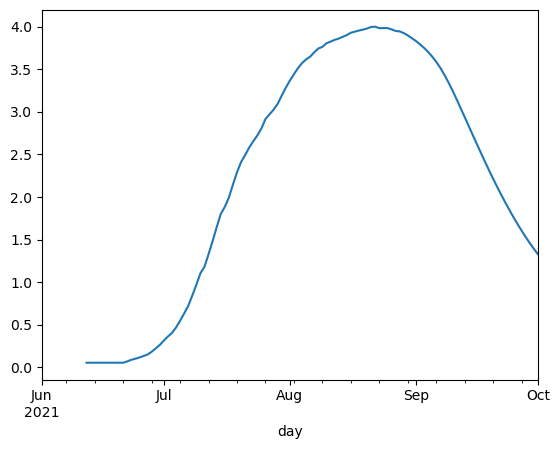

In [32]:
res_2021.LAI.plot()

In [90]:
yield_dict = {
        "ZDN180": {"0": [6796, 6274],
                   "90": [8288, 7397],
                   "180": [9607, 8426],
                   "270": [9573, 8346]
                   }
    }

In [1]:
import numpy as np

In [3]:
bounds = {
        "SLATB001": np.arange(0.0013, 0.0039, 0.0001),
        "SLATB003": np.arange(0.0005, 0.0015, 0.0001),
        "SPAN": np.arange(16.5, 50.5, 0.5),
        "EFFTB003": np.arange(0.225, 0.675, 0.001),
        "TMNFTB003": np.arange(0.5, 1.2, 0.1),
        "CVO": np.arange(0.4955, 0.9065, 0.0001),
        "FLTB001": np.arange(0.465, 0.775, 0.001),
        "TDWI": np.arange(25, 80, 1),
        "CVS": np.arange(0.329, 0.987, 0.001),
        "EFFTB001": np.arange(0.25, 0.75, 0.01),
        "KDIFTB003": np.arange(0.30, 0.90, 0.01),
        "NCRIT_FR": np.arange(0.50, 1.50, 0.01),
        "AMAXTB001": np.arange(35.0, 90.0, 2),
        "NMAXSO": np.arange(0.011, 0.033, 0.001),

    }